In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=7)

# Assuming that you have images with size (48, 48)
model = ResNet18()
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Define the ResNet model and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

# Load the data
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def get_dataloaders(root_dir, bs=64, augment=True):
    mu, st = 0, 255

    test_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(mu,), std=(st,)),
    ])

    if augment:
        train_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
            transforms.RandomApply([transforms.ColorJitter(
                brightness=0.5, contrast=0.5, saturation=0.5)], p=0.5),
            transforms.RandomApply(
                [transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=(mu,), std=(st,)),
            transforms.RandomErasing(),
        ])
    else:
        train_transform = test_transform

    train_dataset = ImageFolder(root=root_dir + '/train', transform=train_transform)
    test_dataset = ImageFolder(root=root_dir + '/test', transform=test_transform)
    trainloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=2)

    return trainloader, testloader

# Example usage:
trainloader, testloader = get_dataloaders(root_dir='/kaggle/input/fer2013', augment=True)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
num_epochs = 200  # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(trainloader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Testing
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = correct_test / total_test
    test_loss /= len(testloader)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    # Print metrics after each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Epoch 1/200, Training Loss: 1.8158, Training Accuracy: 0.2440, Testing Loss: 1.7889, Testing Accuracy: 0.2530
Epoch 2/200, Training Loss: 1.7923, Training Accuracy: 0.2539, Testing Loss: 1.7448, Testing Accuracy: 0.2917
Epoch 3/200, Training Loss: 1.7278, Training Accuracy: 0.2993, Testing Loss: 1.5655, Testing Accuracy: 0.3810
Epoch 4/200, Training Loss: 1.5790, Training Accuracy: 0.3772, Testing Loss: 1.4252, Testing Accuracy: 0.4250
Epoch 5/200, Training Loss: 1.4434, Training Accuracy: 0.4378, Testing Loss: 1.2561, Testing Accuracy: 0.5116
Epoch 6/200, Training Loss: 1.3389, Training Accuracy: 0.4873, Testing Loss: 1.1954, Testing Accuracy: 0.5368
Epoch 7/200, Training Loss: 1.2774, Training Accuracy: 0.5116, Testing Loss: 1.1627, Testing Accuracy: 0.5534
Epoch 8/200, Training Loss: 1.2367, Training Accuracy: 0.5287, Testing Loss: 1.0914, Testing Accuracy: 0.5829
Epoch 9/200, Training Loss: 1.1969, Training Accuracy: 0.5437, Testing Loss: 1.1015, Testing Accuracy: 0.5779
Epoch 10/2

KeyboardInterrupt: 

We stopped the above code at 120 epochs because of the computational limits and the testing accuracy got stagnant at around 70%. It is not the code error

Training and Validation Loss

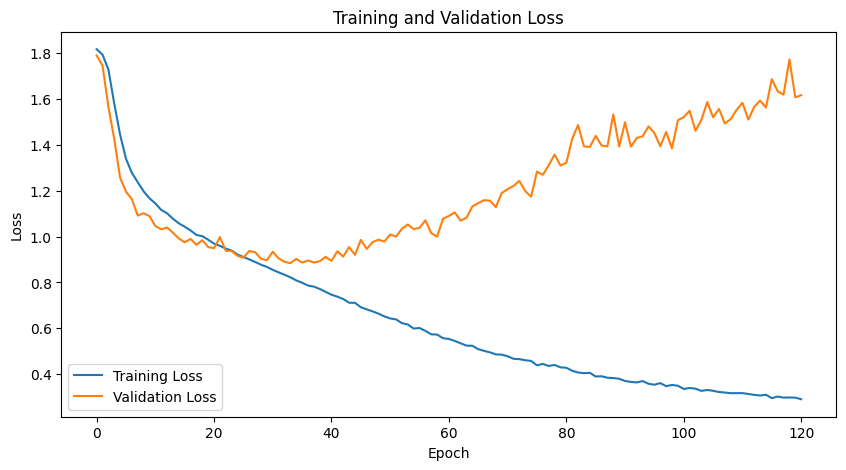

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

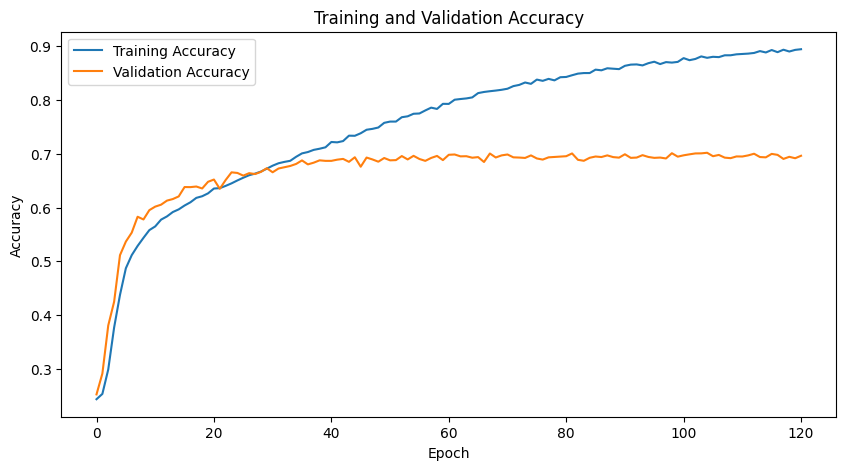

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Correctly Predicted Images:


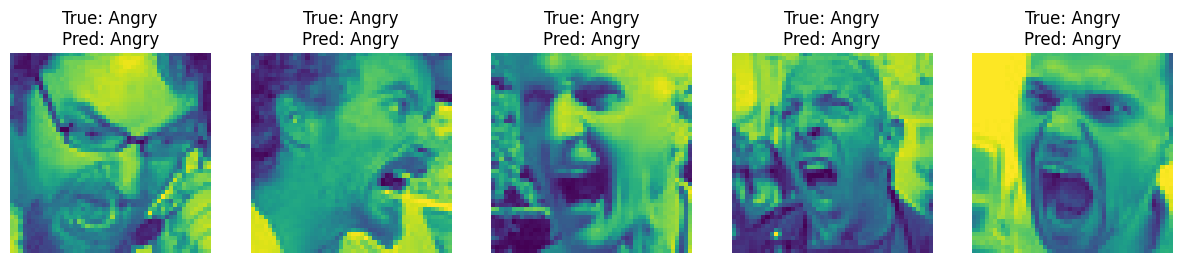

Incorrectly Predicted Images:


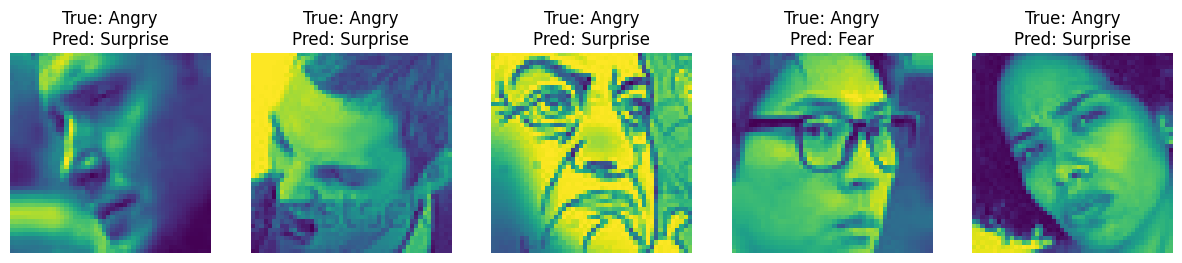

In [ ]:
model.eval()
correct = 0
total = 0
correct_images_info = []
incorrect_images_info = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        correct_mask = predicted.eq(labels)
        incorrect_mask = ~correct_mask

        correct_images = inputs[correct_mask]
        correct_labels = labels[correct_mask]
        correct_predictions = predicted[correct_mask]

        incorrect_images = inputs[incorrect_mask]
        incorrect_labels = labels[incorrect_mask]
        incorrect_predictions = predicted[incorrect_mask]

        class_names = {0: 'Angry',1: 'Disgust',2: 'Fear',3: 'Happy',4: 'Sad',5: 'Surprise',6: 'Neutral'}

        # Store information about correctly predicted images
        for i in range(len(correct_images)):
            correct_images_info.append({
                'image': correct_images[i].cpu().numpy(),
                'true_label': correct_labels[i].item(),
                'predicted_label': correct_predictions[i].item()
            })

        # Store information about incorrectly predicted images
        for i in range(len(incorrect_images)):
            incorrect_images_info.append({
                'image': incorrect_images[i].cpu().numpy(),
                'true_label': incorrect_labels[i].item(),
                'predicted_label': incorrect_predictions[i].item()
            })

        break  # Only process the first batch

# Print some correctly predicted images
print("Correctly Predicted Images:")
plt.figure(figsize=(15, 3))
for i in range(min(5, len(correct_images_info))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(correct_images_info[i]['image'].transpose(1, 2, 0).squeeze())
    true_label = class_names[correct_images_info[i]["true_label"]]
    pred_label = class_names[correct_images_info[i]["predicted_label"]]
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

# Print some incorrectly predicted images
print("Incorrectly Predicted Images:")
plt.figure(figsize=(15, 3))
for i in range(min(5, len(incorrect_images_info))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(incorrect_images_info[i]['image'].transpose(1, 2, 0).squeeze())
    true_label = class_names[incorrect_images_info[i]["true_label"]]
    pred_label = class_names[incorrect_images_info[i]["predicted_label"]]
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

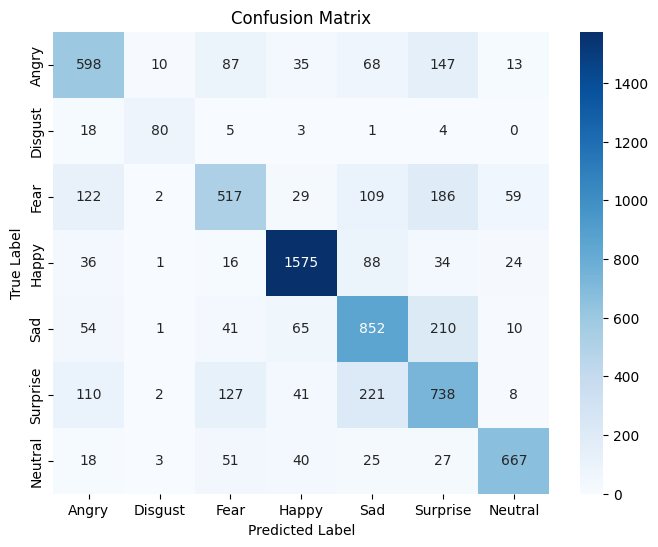

In [ ]:
from sklearn.metrics import confusion_matrix
model.eval()
with torch.no_grad():
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        all_labels = []
        all_predictions = []
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted_valid = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted_valid.eq(labels).sum().item()

            # Store labels and predictions for the confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_valid.cpu().numpy())
import seaborn as sn
import pandas as pd
conf_matrix = confusion_matrix(all_labels, all_predictions)
conf_df = pd.DataFrame(conf_matrix, index=class_names.values(), columns=class_names.values())
plt.figure(figsize=(8, 6))
sn.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()